In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plot
import torch.nn.functional as F

In [2]:
from datetime import datetime
import torchvision.transforms as transforms

In [5]:
transformer_train = torchvision.transforms.Compose([
  # transforms.ColorJitter(
  #    brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
  # ),
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(p=0.5),
  # transforms.RandomRotation(degrees=15),
  transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # transforms.RandomPerspective(),
  transforms.ToTensor()
  ]
)

In [6]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True
)

test_data = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 170M/170M [00:04<00:00, 39.0MB/s]


In [7]:
K = len(set(train_dataset.targets))

In [8]:
K

10

In [9]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size
)

In [10]:
class CNN(nn.Module):
  def __init__(self, K) -> None:
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
    )


    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
    )

    self.fc1 = nn.Linear(4 * 4 * 128, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, X):
    out = self.conv1(X)
    out = self.conv2(out)
    out = self.conv3(out)
    out = out.view(-1, 128 * 4 * 4)
    out = F.dropout(out, p=0.5)
    out = F.relu(self.fc1(out))
    out = F.dropout(out, p=0.2)
    out = self.fc2(out)
    return out


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model = CNN(K)
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [12]:

def batch_gd(model: nn.Module, criterion: nn.MSELoss, optimizer: torch.optim.Adam, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t_0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    dt = datetime.now() - t_0

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)


      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f"Epoch: {it}/{epochs}, Train loss: {train_loss:.4f}, Test loss {test_loss:.4f}")
    print(f"Train time {dt}")

  return train_losses, test_losses


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:
epochs = 60
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs)

Epoch: 0/60, Train loss: 1.4985, Test loss 1.1500
Train time 0:00:25.195543
Epoch: 1/60, Train loss: 1.0673, Test loss 0.9480
Train time 0:00:25.636044
Epoch: 2/60, Train loss: 0.8892, Test loss 0.8351
Train time 0:00:25.101121
Epoch: 3/60, Train loss: 0.7862, Test loss 0.7819
Train time 0:00:25.120187
Epoch: 4/60, Train loss: 0.7162, Test loss 0.6957
Train time 0:00:25.143018
Epoch: 5/60, Train loss: 0.6560, Test loss 0.6440
Train time 0:00:25.122688
Epoch: 6/60, Train loss: 0.6163, Test loss 0.6555
Train time 0:00:25.134843
Epoch: 7/60, Train loss: 0.5837, Test loss 0.5992
Train time 0:00:25.048863
Epoch: 8/60, Train loss: 0.5547, Test loss 0.5934
Train time 0:00:25.400055
Epoch: 9/60, Train loss: 0.5363, Test loss 0.5418
Train time 0:00:25.534498
Epoch: 10/60, Train loss: 0.5147, Test loss 0.5573
Train time 0:00:25.016950
Epoch: 11/60, Train loss: 0.4963, Test loss 0.5216
Train time 0:00:25.089761
Epoch: 12/60, Train loss: 0.4779, Test loss 0.5607
Train time 0:00:25.390352
Epoch: 13

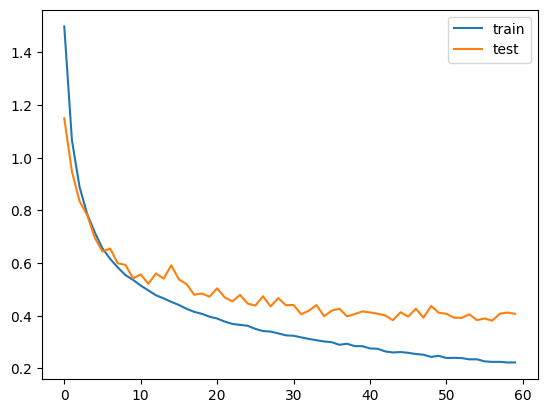

In [19]:
plot.plot(train_losses, label="train")
plot.plot(test_losses, label='test')
plot.legend()
plot.show()

In [20]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)


  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f} Test acc: {test_acc:.4f}")

Train acc: 0.9279 Test acc: 0.9197


In [21]:


from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="COnfusion Matrix",
                          cmap=plot.cm.Blues
                          ):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized")
  else:
    print("Not Normalized")
  print(cm)

  plot.imshow(cm, interpolation="nearest", cmap=cmap)
  plot.title(title)
  tick_marks = np.arange(len(classes))
  plot.xticks(tick_marks, classes, rotation=45)
  plot.xticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plot.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plot.tight_layout()
  plot.ylabel("True Label")
  plot.xlabel("Predicted Label")
  plot.show()

Not Normalized
[[898  20  28   9   9   1   1   3  26   5]
 [  5 970   0   2   0   0   1   2   3  17]
 [ 28   0 859  35  23  15  31   7   2   0]
 [ 15   1  30 808  31  67  26   9   6   7]
 [  5   1  37  51 847  18  27  10   3   1]
 [  7   0  26 119  19 801  13  14   0   1]
 [  3   3  19  36   7   8 920   2   1   1]
 [ 14   0  11  32  37  22   4 876   0   4]
 [ 39  18   4  10   0   0   5   3 915   6]
 [ 18  54   3   7   0   2   0   1   7 908]]


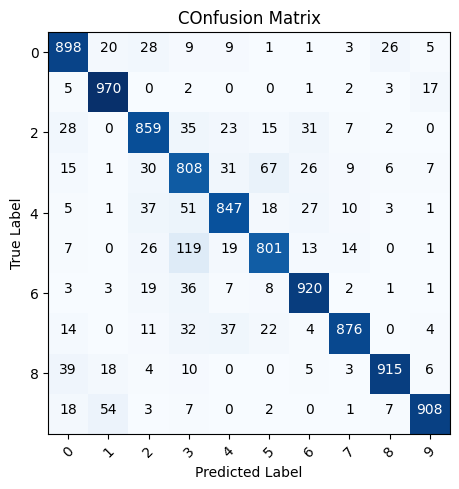

In [22]:
x_test = test_data.data
y_test = test_data.targets

p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


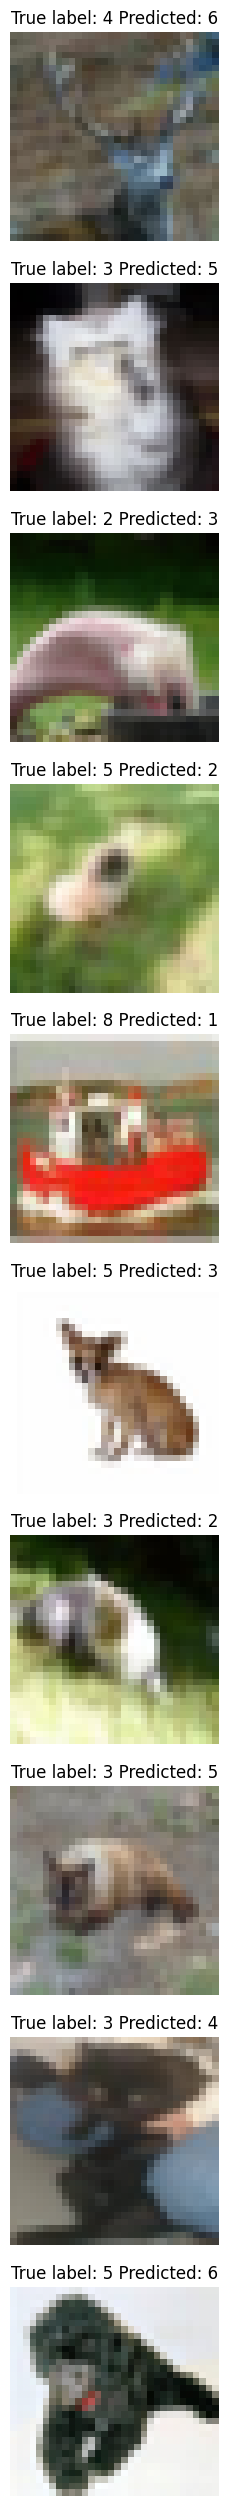

In [23]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassified_idx, 10, replace=False)
plot.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
  plot.subplot(10, 1, j + 1)
  plot.axis("off")
  print(x_test[i].shape)
  plot.imshow(x_test[i].reshape(32, 32, 3))
  plot.title(f"True label: {y_test[i]} Predicted: {p_test[i]}")